# Flowchart Optimization

By using the simulator in conjuction with nonlinear root-finding methods such as the bisection method, we can optimize flowcharts to determine precisely how much money/eco we should have at a certain point in the game in order to meet our goals. In this document I provide two such examples:

1. Optimizing boat alch spac so that we are able to buy permaspike before R28 and super mines before R30.
2. Optimizing boat mortar play on bot factory to have *just* enough cash for a panic sell into abat in case we receive a large enough rush.

In [1]:
import b2sim as b2
from copy import deepcopy as dc

## Late-Game BAS

Twitch streamer spoonoil is famous for his utilization of spac + alch in BAS (boat, alch, spac) to leverage large rushes while also effectively protecting against the counter rush. In the following example, we start from Round 24 in a quarter-stalled game with access to 4 favored trades and determine how much pink eco spoonoil should eco to before stopping to save up and buy essential defense. The essential purchases are given like so:

| Build Item | Time to Purchase |
|------------|------------------|
| 025 Spac | Round 27.9 |
| 502 Spac | Round 29.9 |

Let's start by defining the *static* parts of our flowchart, or the things we *don't* need to optimize:

In [2]:
rounds = b2.Rounds(0.20)

buy_queue = [
    [b2.buyDefense(37150, message = "025 spac", min_buy_time = rounds.getTimeFromRound(27.9))],
    [b2.buyDefense(124650, message = "502 spac", min_buy_time = rounds.getTimeFromRound(29.9))]
]

boat_farms = [
    b2.initBoatFarm(purchase_time = rounds.getTimeFromRound(24), upgrade = 4),
    b2.initBoatFarm(purchase_time = rounds.getTimeFromRound(24), upgrade = 4),
    b2.initBoatFarm(purchase_time = rounds.getTimeFromRound(24), upgrade = 4),
    b2.initBoatFarm(purchase_time = rounds.getTimeFromRound(24), upgrade = 4),
]

Next, I'm going to define a function and put the parts of the flowchart I *do* need to optimize in there. In this case, the amount of eco we need to stop at is not clear. The function will, from a given indicated `stopping_eco`, return 'True' if we buy both our upgrades in the buy_queue on time and 'False' otherwise.

In [3]:
def foo(stopping_eco, rounds, eco_queue, buy_queue, boat_farms):

    initial_state_game = {
        'Cash': 0,
        'Eco': 3500,
        'Eco Send': b2.ecoSend(send_name = 'Grouped Pinks', max_eco_amount = stopping_eco),
        'Rounds': rounds,
        'Game Round': 24,
        'Boat Farms': dc(boat_farms),
        'Buy Queue': dc(buy_queue),
        'Eco Queue': dc(eco_queue)
    }

    game_state = b2.GameState(initial_state_game)

    #First, check if we get permaspike on or before R28.
    #Next, check if we get spiked mines on or before R30
    game_state.fastForward(target_round = 28)
    if len(game_state.buy_queue) > 1:
        return False
    
    game_state.fastForward(target_round = 30)
    if len(game_state.buy_queue) > 0:
        return False
    else:
        return True

Next, we find the maximum stopping eco that still lets us afford essential defense in time by using bisection method

In [4]:
#Determine the *best* stopping time
stopping_eco_low = 3500
stopping_eco_high = 10000
iterations = 25

for i in range(iterations):
    c = 0.5*(stopping_eco_low + stopping_eco_high)

    if foo(c, rounds, [], buy_queue, boat_farms) == True:
        stopping_eco_low = c
    else:
        stopping_eco_high = c

max_stopping_eco = 0.5*(stopping_eco_low + stopping_eco_high)
print("The maximum stopping eco for the simulation is %s"%('{0:.1f}'.format(max_stopping_eco)))

The maximum stopping eco for the simulation is 5808.8


Finally, let's verify that what the simulator says actually holds true...

,Time,Type,Message
0,564.5,Round,Round 24 start
1,564.5,Eco,Change eco to Zero
2,629.4,Round,Round 25 start
3,670.5,Round,Round 26 start
4,702.8,Round,Round 27 start
5,729.4,Buy,025 spac
6,732.3,Round,Round 28 start
7,761.0,Round,Round 29 start
8,810.0,Buy,502 spac
9,812.9,Round,Round 30 start


The current cash and eco are (5700.0,3500)


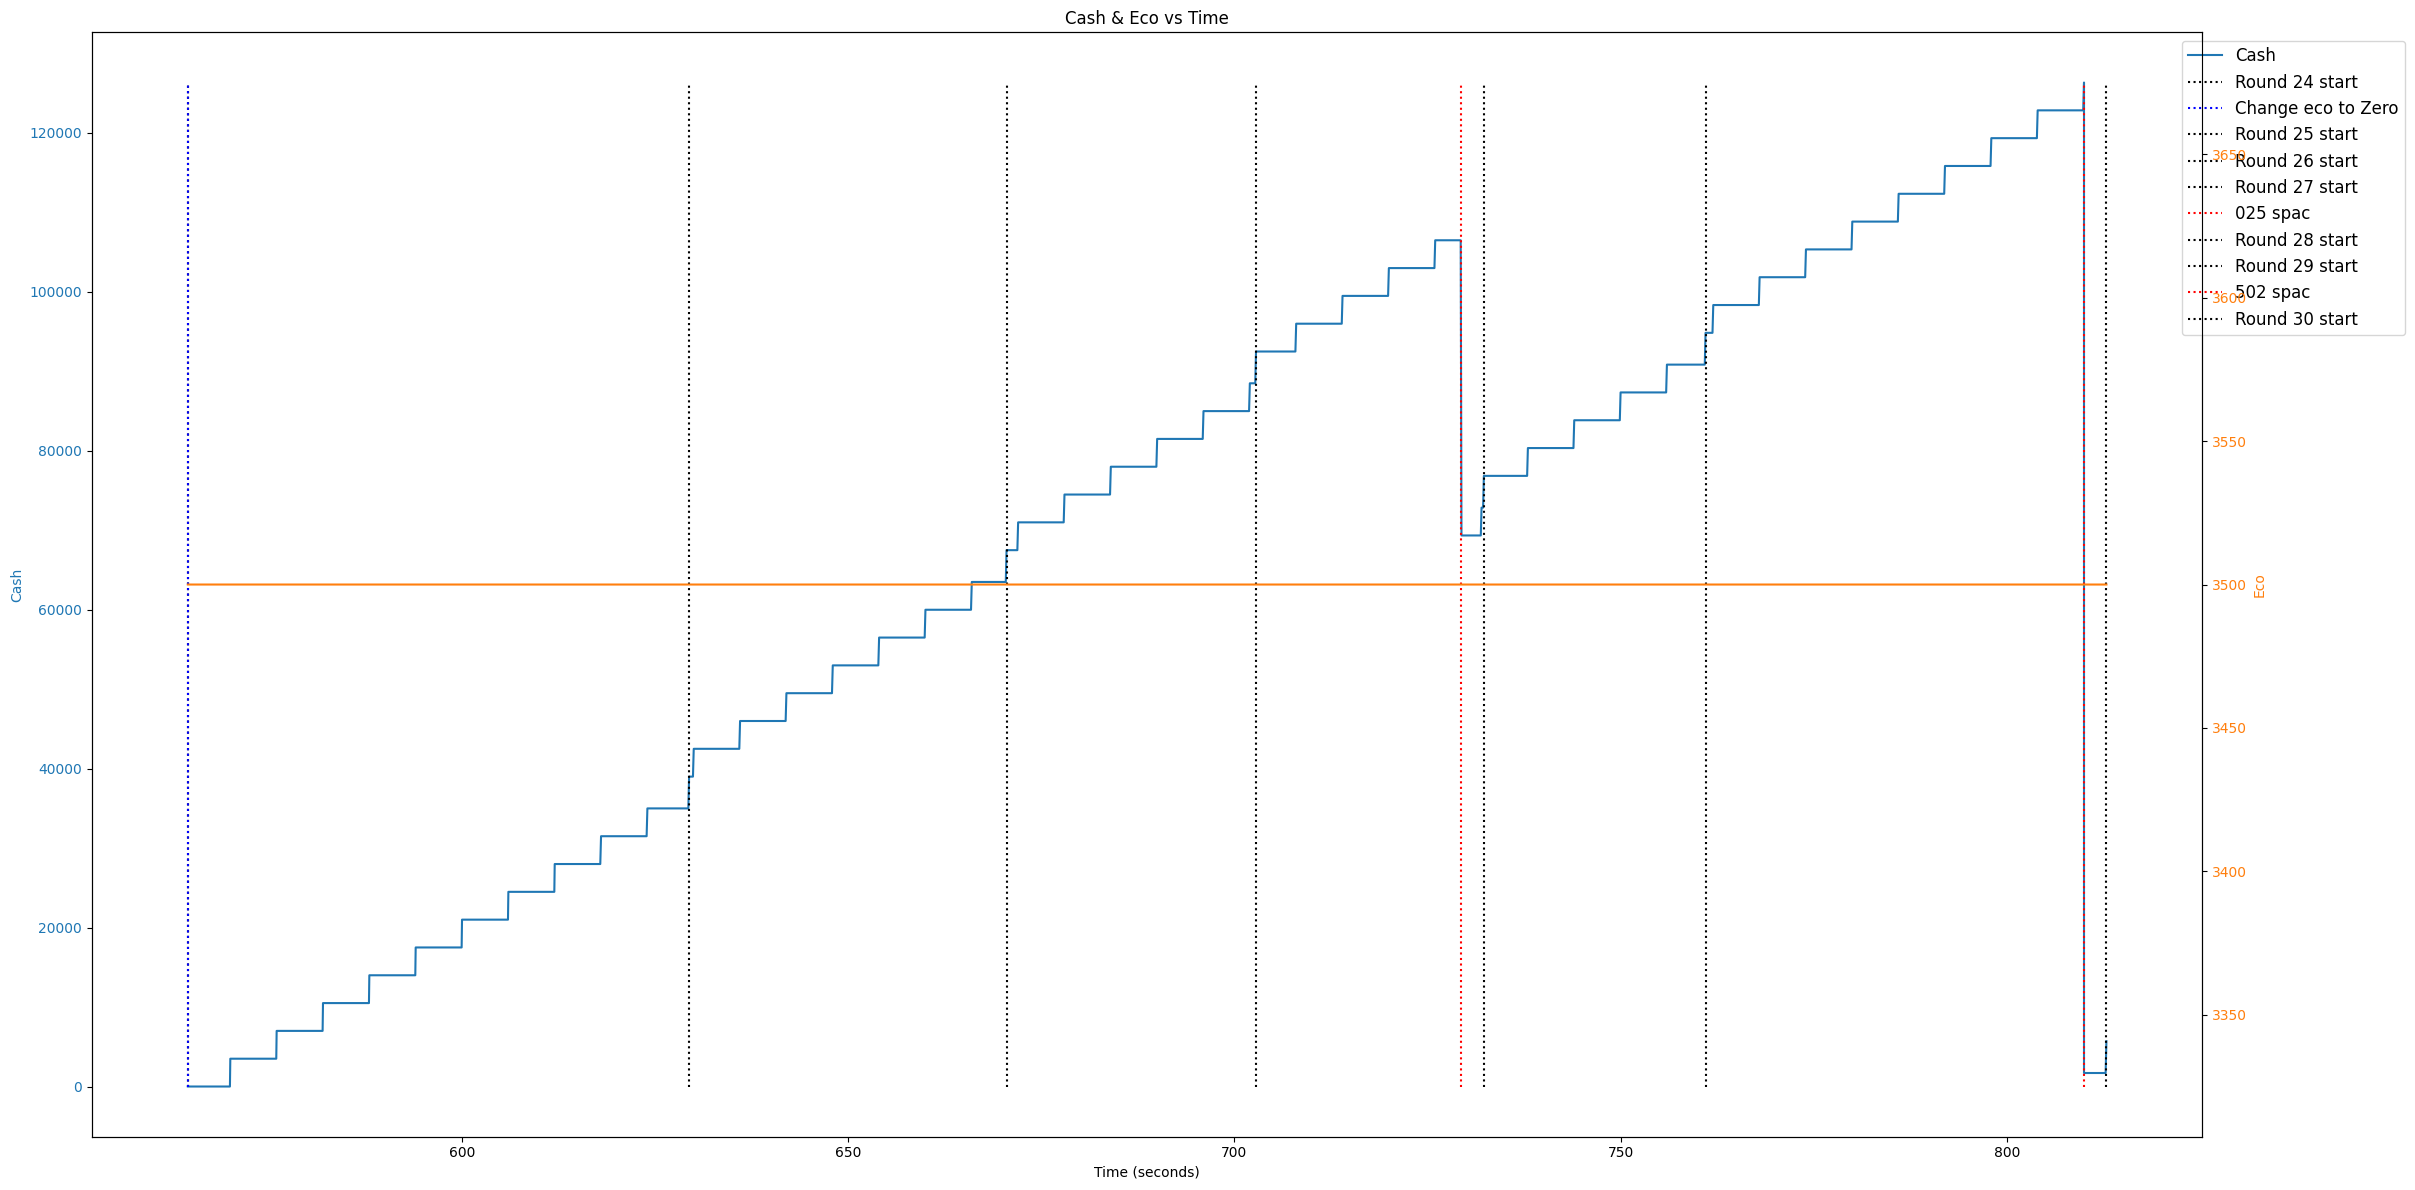

In [5]:
initial_state_game = {
        'Cash': 0,
        'Eco': 3500,
        'Eco Send': b2.ecoSend(send_name = 'Grouped Pinks', max_eco_amount = max_stopping_eco-1),
        'Rounds': rounds,
        'Game Round': 24,
        'Boat Farms': boat_farms,
        'Buy Queue': buy_queue
    }

game_state = b2.GameState(initial_state_game)
game_state.fastForward(target_round = 30)
game_state.viewCashEcoHistory((24,12))
print("The current cash and eco are (%s,%s)"%(game_state.cash, game_state.eco))
b2.writeLog(game_state.logs, filename = 'bas_lategame')

## Boat Mortar midgame on Bot Factory

Here, I want to make sure if I get rushed on R13 I can safely sell into "big one" to defend. Assuming my only eco'ing is that of Spaced Rainbows for the first half of R12, how much eco should I have on R10 for me to be able to save up and this be a feasible defensive option?

The minimum eco that we need by Round 10 is 844.8749780654907


,Time,Type,Message
0,234.5,Round,Round 10 start
1,234.5,Eco,Change eco to Zero
2,248.2,Round,Round 11 start
3,265.2,Round,Round 12 start
4,265.2,Eco,Change eco to Spaced Rainbows
5,275.4,Eco,Change eco to Zero
6,285.5,Round,Round 13 start
7,285.5,Buy,"Sell boat farm 0, buy mortar"


The current cash and eco are (7.999824523925781,947.8749780654907)


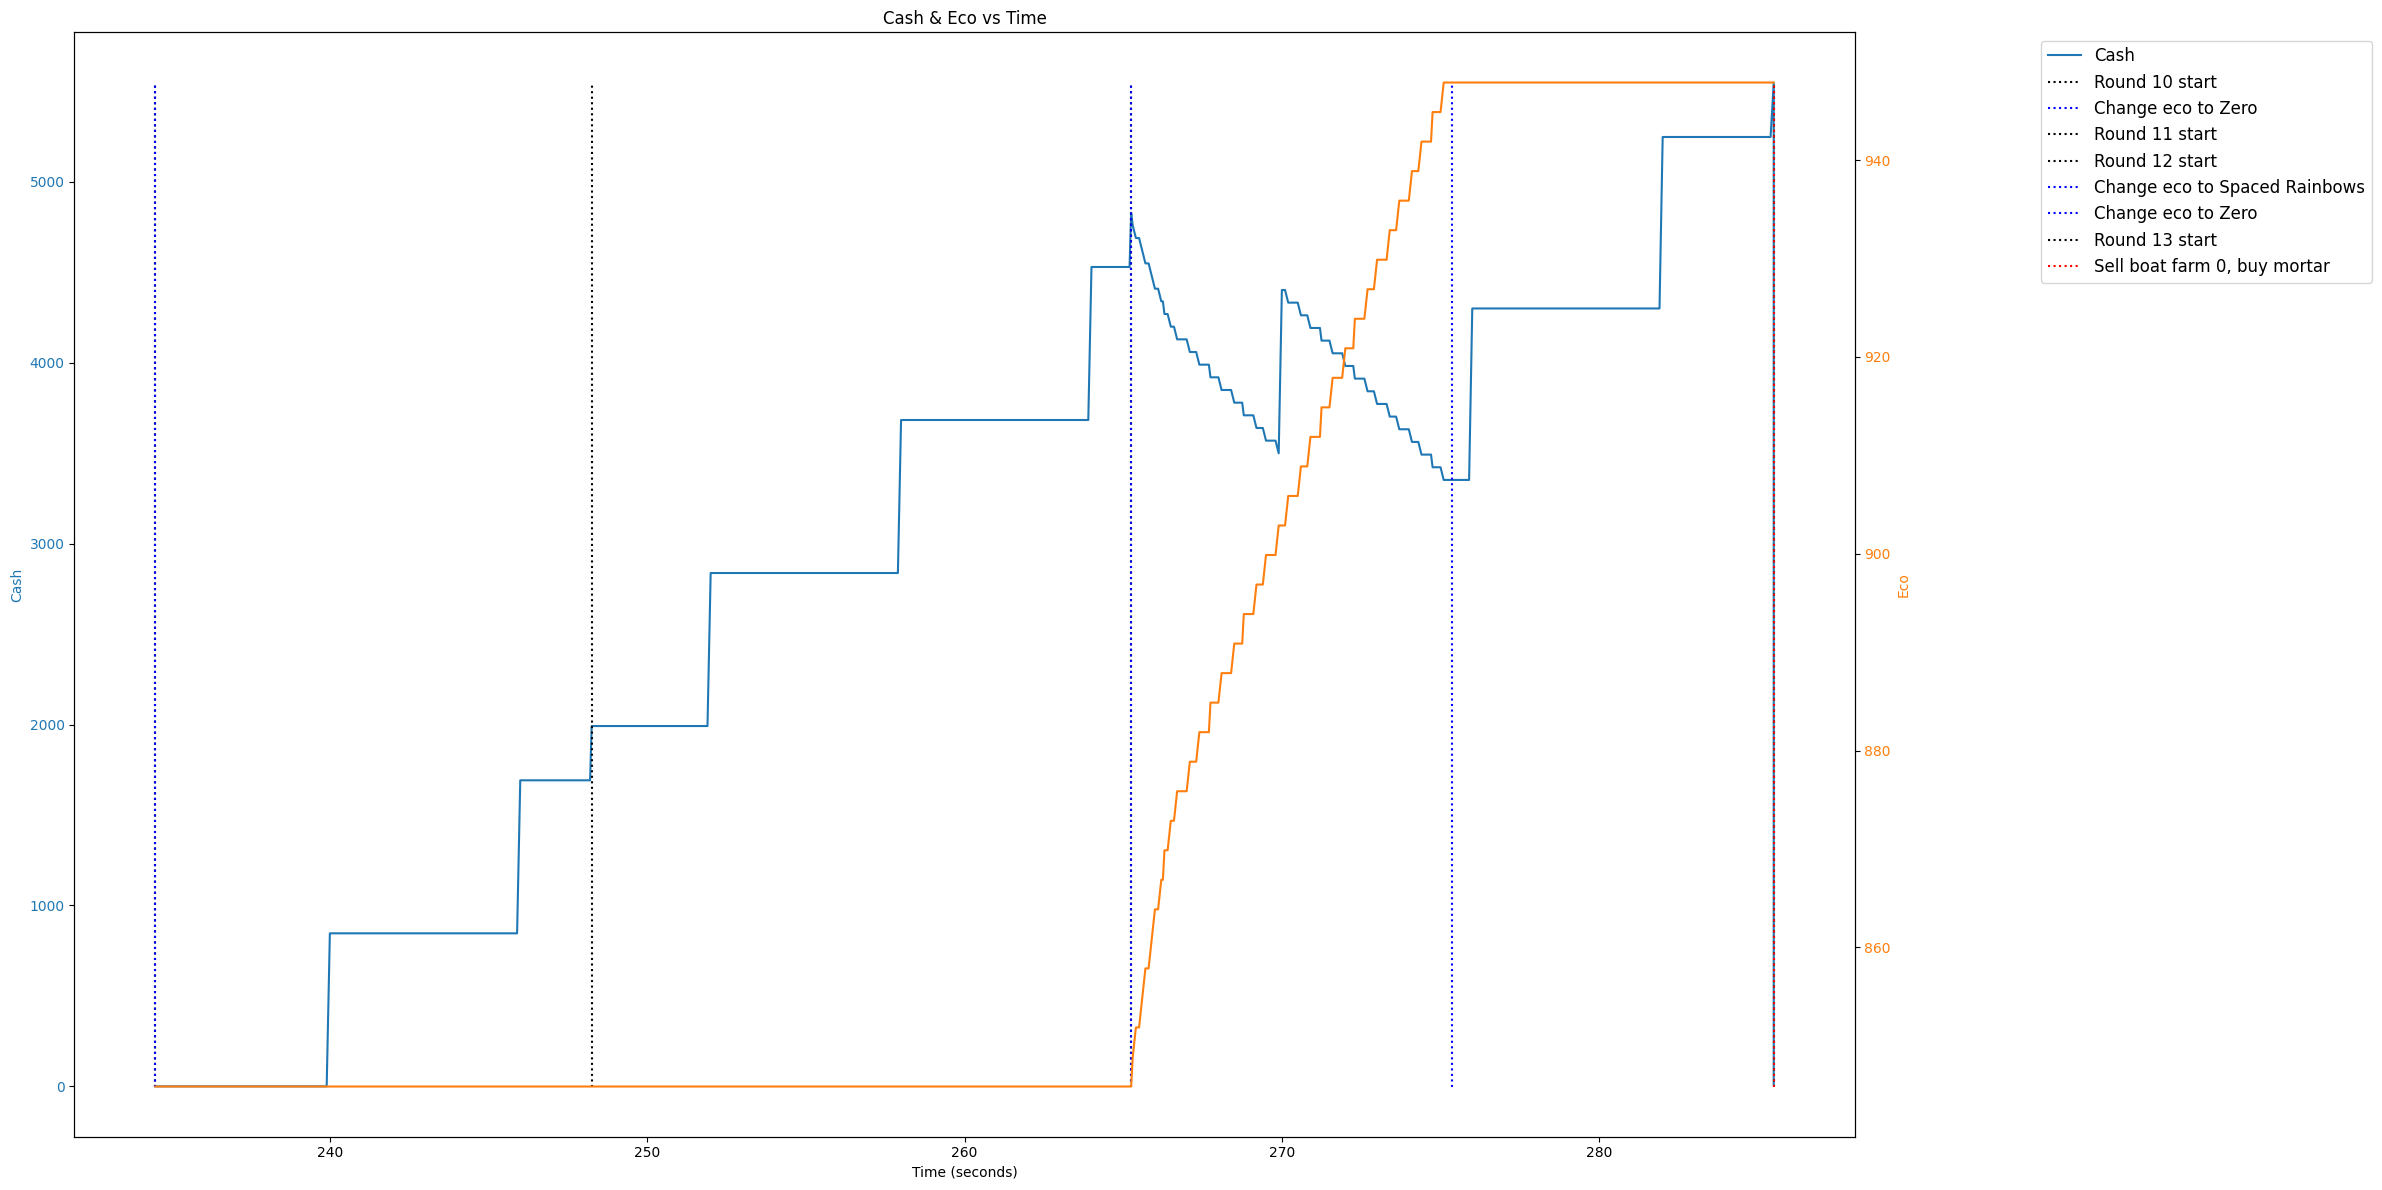

In [6]:
rounds = b2.Rounds(0.25) #Quarter-stall is probably a good assumption

buy_queue = [
    #Sell boat, upgrade mortar to 420
    [b2.sellBoatFarm(0), b2.buyDefense(7500, min_buy_time=rounds.getTimeFromRound(13), message="buy mortar")],
]

boat_farms = [
    b2.initBoatFarm(rounds.getTimeFromRound(5.9),3)
]

eco_queue = [
    b2.ecoSend(time = rounds.getTimeFromRound(12), send_name='Spaced Rainbows'),
    b2.ecoSend(time = rounds.getTimeFromRound(12.5), send_name='Zero')
]

def foo(starting_eco):

    initial_state_game = {
        'Cash': 0,
        'Eco': starting_eco,
        'Eco Send': b2.ecoSend(send_name='Zero'),
        'Boat Farms': dc(boat_farms),
        'Rounds': rounds,
        'Game Round': 10,
        'Eco Queue': dc(eco_queue),
        'Buy Queue': dc(buy_queue)
    }

    game_state = b2.GameState(initial_state_game)
    game_state.fastForward(target_round = 13)

    if len(game_state.buy_queue) > 0:
        return False
    else:
        return True
    
a = 750
b = 1000
iterations = 20

for i in range(iterations):
    c = 0.5*(a+b)
    if foo(c):
        b = c
    else:
        a = c

starting_eco = 0.5*(a+b)
print("The minimum eco that we need by Round 10 is %s"%(starting_eco))

initial_state_game = {
    'Cash': 0,
    'Eco': starting_eco +1,
    'Eco Send': b2.ecoSend(send_name='Zero'),
    'Boat Farms': boat_farms,
    'Eco Queue': eco_queue,
    'Rounds': rounds,
    'Game Round': 10,
    'Buy Queue': buy_queue
}

game_state = b2.GameState(initial_state_game)
game_state.fastForward(target_round = 13)
game_state.viewCashEcoHistory((24,12))
print("The current cash and eco are (%s,%s)"%(game_state.cash, game_state.eco))
b2.writeLog(game_state.logs, filename = 'saving_for_mortar')